In [194]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, 
    average_precision_score, brier_score_loss,
    confusion_matrix, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.special import logit
from scipy import stats
import warnings

In [195]:
df=pd.read_parquet('/Users/huangshifeng/Desktop/stage_III_colon_surv/data/post_EDA.parquet', engine='pyarrow')
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Patient_ID            331 non-null    int64         
 1   Dx_Year               331 non-null    int64         
 2   Age                   331 non-null    int64         
 3   Sex                   331 non-null    int64         
 4   BMI                   327 non-null    float64       
 5   ECOG                  314 non-null    Int8          
 6   Tumor_Location        331 non-null    int64         
 7   Tumor_Location_Group  331 non-null    int64         
 8   pT_Stage              331 non-null    category      
 9   pN_Stage              331 non-null    category      
 10  AJCC_Substage         331 non-null    category      
 11  LN_Total              331 non-null    int64         
 12  LN_Positive           331 non-null    int64         
 13  LNR                 

### 先把型態搞定

In [196]:
#'LNR'欄位本來是object，改成float
df['LNR']=df['LNR'].str.replace('%', '')
df['LNR']=round((df['LNR'].astype(float))/100, 3)
print(df['LNR'].head())

#'Sex'本來是1/2，要改成0/1
df['Sex']=df['Sex'].astype(str).str.replace('2', '0')
df['Sex']=df['Sex'].astype('int64')

#'Tumor_Location_Group'本來是1/2，要改成0/1
df['Tumor_Location_Group']=df['Tumor_Location_Group'].astype(str).str.replace('1', '0')
df['Tumor_Location_Group']=df['Tumor_Location_Group'].astype(str).str.replace('2', '1')
df['Tumor_Location_Group']=df['Tumor_Location_Group'].astype('int64')

#'LVI', 'PNI'改成Int
df['LVI']=df['LVI'].astype('Int64')
df['PNI']=df['PNI'].astype('Int64')

#'Differentiation' 9改成NaN
df['Differentiation']=df['Differentiation'].replace(9, np.nan)
df['Differentiation']=df['Differentiation'].astype('Int64')

df['ECOG']=df['ECOG'].astype('Int64')
df['edr_18m']=df['edr_18m'].astype('Int64')
df['edr_24m']=df['edr_24m'].astype('Int64')

0    0.706
1    0.059
2    0.000
3    0.176
4    0.167
Name: LNR, dtype: float64


In [197]:
#MSI_Status欄位做修改
df=df.rename(columns={'MSI_Status':'MSI_High'})
df['MSI_High']=df['MSI_High'].str.replace('MSI-H', '1')
df['MSI_High']=df['MSI_High'].str.replace('MSS', '0')
df['MSI_High']=df['MSI_High'].astype('Int64')
df['MSI_High'].value_counts(dropna=False)

MSI_High
0       303
1        26
<NA>      2
Name: count, dtype: Int64

In [198]:
df['Tumor_Location_Group'].value_counts(dropna=False)

Tumor_Location_Group
1    216
0    115
Name: count, dtype: int64

### 定義特徵

In [199]:
#ordinal orders mapping成numericals for LASSO Logistic
# pT_Stage Mapping
t_mapping = {
    '1': 1, 
    '2': 2, 
    '3': 3, 
    '4A': 4, 
    '4B': 5
}

df['pT_Stage_Num'] = df['pT_Stage'].astype(str).map(t_mapping)
df['pT_Stage_Num']=df['pT_Stage_Num'].astype('Int64')
# pN_Stage Mapping
# N1a(1) < N1b(2-3) < N1c(TD) < N2a(4-6) < N2b(7+)
n_mapping = {
    '1A': 1, 
    '1B': 2, 
    '1C': 3, # N1c (Tumor Deposits only) 預後通常介於 N1 和 N2 之間
    '2A': 4, 
    '2B': 5
}

df['pN_Stage_Num'] = df['pN_Stage'].astype(str).map(n_mapping)
df['pN_Stage_Num']=df['pN_Stage_Num'].astype('Int64')
# C. AJCC_Substage Mapping
ajcc_mapping = {
    '3A': 1, 
    '3B': 2, 
    '3C': 3
}
df['AJCC_Substage_Num'] = df['AJCC_Substage'].astype(str).map(ajcc_mapping)
df['AJCC_Substage_Num']=df['AJCC_Substage_Num'].astype('Int64')

#把prepare for ML的表格輸出
df.to_parquet('/Users/huangshifeng/Desktop/stage_III_colon_surv/data/all_cases_prepared_for_ML.parquet', engine='pyarrow')

In [200]:
num_features = [
    'Age', 'BMI', 'LN_Total', 'LN_Positive', 
    'Tumor_Size_cm', 'PreOp_Albumin', 'Log_CEA_PreOp', 'LNR', 'pT_Stage_Num', 'pN_Stage_Num', 'AJCC_Substage_Num', 'ECOG', 'Differentiation'
]
bin_features = [
    'Sex', 'LVI', 'PNI', 'Tumor_Deposits', 
    'Mucinous_Any', 'Signet_Ring', 'Tumor_Location_Group', 'MSI_High'
]

nom_features = ['Histology']

target_col = 'edr_18m'
total_features = num_features + bin_features + nom_features

### 建立Pipeline

In [201]:
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)), 
    ('scaler', StandardScaler())
])

bin_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

nom_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('bin', bin_transformer, bin_features),
        ('nom', nom_transformer, nom_features)
    ],
    remainder='drop'
)

### 建立LASSO主模型

In [202]:
lasso_model = LogisticRegressionCV(
    cv=5,
    penalty='l1',
    solver='saga', 
    class_weight='balanced', 
    random_state=42,
    max_iter=10000, 
    scoring='roc_auc',
    Cs=np.logspace(-2, 1, 8)
)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', lasso_model)])

### Fit LASSO主模型

In [203]:
warnings.filterwarnings("ignore")

X=df[total_features]
y=df[target_col]

clf.fit(X, y)

print("LASSO with precise encoding finished.")

print("選到的 C：", lasso_model.C_)        # 最後選中的正則化強度
print("係數 shape：", lasso_model.coef_.shape)
print("截距 intercept_：", lasso_model.intercept_)

# 1. 把 preprocessor 跟 LASSO 模型抓出來
preprocessor = clf.named_steps['preprocessor']
lasso_model = clf.named_steps['classifier']

# 2. 取得「展開後」的欄位名稱（含 one-hot）
feature_names = preprocessor.get_feature_names_out()

# 3. 拿到係數，攤平成 1D
coefs = lasso_model.coef_.ravel()

# 4. 組成一個表，順便算絕對值方便排序
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs,
    'abs_coef': np.abs(coefs)
})

# 5. 依照「絕對值大小」排序，從大排到小
coef_df_sorted = coef_df.sort_values('abs_coef', ascending=False)

# 6. 如果你只想看有被 LASSO 留下來的（係數 ≠ 0）
nonzero_coef_df = coef_df_sorted[coef_df_sorted['coef'] != 0]

print("=== 所有變數（含係數=0） ===")
display(coef_df_sorted)

print("=== LASSO 真正選到的變數（coef ≠ 0） ===")
display(nonzero_coef_df)


LASSO with precise encoding finished.
選到的 C： [0.02682696]
係數 shape： (1, 24)
截距 intercept_： [-0.07343315]
=== 所有變數（含係數=0） ===


,feature,coef,abs_coef
10,num__AJCC_Substage_Num,0.30607,0.30607
0,num__Age,0.00000,0.00000
13,bin__Sex,0.00000,0.00000
22,nom__Histology_2,0.00000,0.00000
21,nom__Histology_1,0.00000,0.00000
20,bin__MSI_High,0.00000,0.00000
19,bin__Tumor_Location_Group,0.00000,0.00000
18,bin__Signet_Ring,0.00000,0.00000
17,bin__Mucinous_Any,0.00000,0.00000
16,bin__Tumor_Deposits,0.00000,0.00000


=== LASSO 真正選到的變數（coef ≠ 0） ===


,feature,coef,abs_coef
10,num__AJCC_Substage_Num,0.30607,0.30607


#### 用LASSO跑完只篩出一個變數....改用XGBoost試試看

In [209]:
import sys
sys.version

'3.11.14 (main, Oct  9 2025, 16:16:55) [Clang 17.0.0 (clang-1700.0.13.3)]'

正在使用 XGBoost 重新評估特徵重要性...

【XGBoost 認定的重要變數】


,Feature,Importance
10,AJCC_Substage_Num,0.228280
15,PNI,0.077608
9,pN_Stage_Num,0.071142
7,LNR,0.058211
2,LN_Total,0.051080
12,Differentiation,0.048902
4,Tumor_Size_cm,0.048504
8,pT_Stage_Num,0.047134
3,LN_Positive,0.045555
0,Age,0.042442


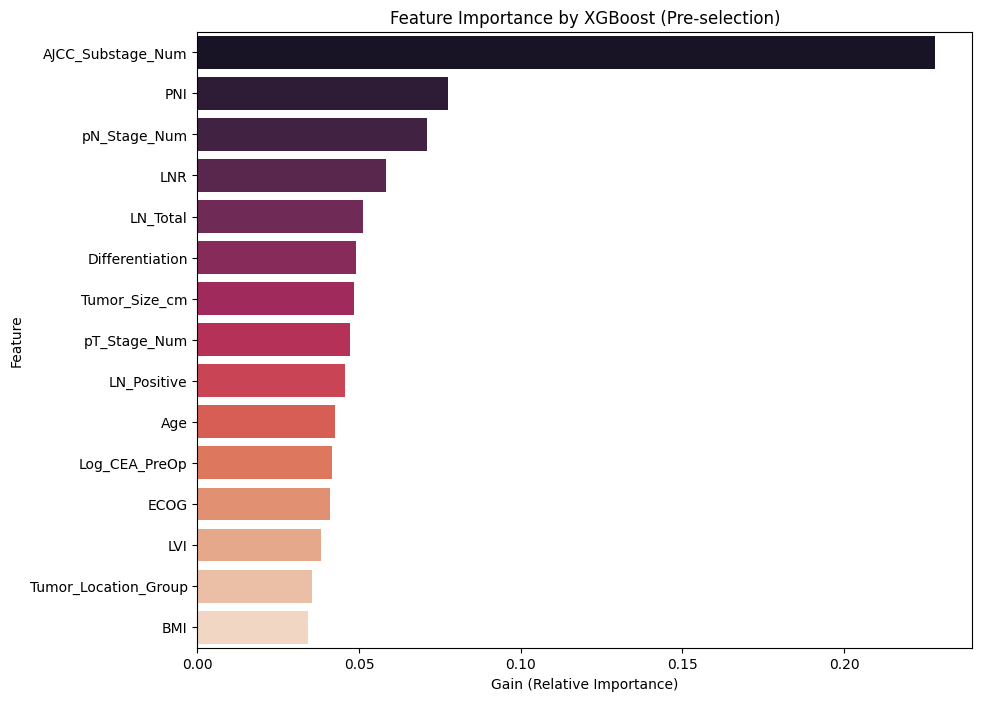

In [204]:
from xgboost import XGBClassifier

# ==========================================
# 改用 XGBoost 進行特徵篩選
# ==========================================

# 1. 準備 XGBoost 模型
# 我們稍微放寬樹的深度 (max_depth=5)，讓它有機會去抓那些微弱的訊號
xgb_selector = XGBClassifier(
    n_estimators=200,
    max_depth=5,         # 稍微深一點，讓它能捕捉互動關係
    learning_rate=0.05,
    scale_pos_weight=(len(y) - sum(y)) / sum(y), # 處理不平衡
    random_state=42,
    n_jobs=-1,
    eval_metric='auc'
)

# 2. 建立 Pipeline
# 注意：XGBoost 其實不需要 StandardScaler，但保留也沒壞處
# 重點是我們用原本的 preprocessor 處理完後直接進 XGB
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_selector)
])

# 3. 訓練
print("正在使用 XGBoost 重新評估特徵重要性...")
xgb_pipeline.fit(X, y)

# ==========================================
# 4. 提取結果
# ==========================================

# 抓出特徵名稱
nom_names = xgb_pipeline.named_steps['preprocessor'].transformers_[2][1]\
   .named_steps['onehot'].get_feature_names_out(nom_features)
all_feature_names = np.r_[num_features, bin_features, nom_names]

# 抓出重要性 (Feature Importances)
importances = xgb_pipeline.named_steps['classifier'].feature_importances_

# 整理成表格
xgb_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 顯示前 15 名
print("\n【XGBoost 認定的重要變數】")
display(xgb_df.head(15))

# 畫圖
plt.figure(figsize=(10, 8))
sns.barplot(data=xgb_df.head(15), x='Importance', y='Feature', palette='rocket')
plt.title('Feature Importance by XGBoost (Pre-selection)')
plt.xlabel('Gain (Relative Importance)')
plt.show()